In [2]:
import sys
import os
sys.path.append('/g/data/jk72/ll6859/ACCESS_aero_eval/')
from aercode import *
import matplotlib 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import xarray as xr
import glob as gb
import cartopy.crs as ccrs
import seaborn as sns
import scipy.special
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

import dask
import warnings
from dask.distributed import Client

In [3]:
plt.style.use('default')
warnings.filterwarnings('ignore')

## Table of Contents: <a class="anchor" id="top"></a>
* [Overall Evaluation](#first-bullet)
* [Regional Evaluation](#second-bullet)
* [Temporal Evaluation](#third-bullet)
* [Radon Evaluation](#fourth-bullet)
* [BLN Evaluation](#fifth-bullet)

# Load in data

In [9]:
# load in data
f_path = '/g/data/jk72/ll6859/ACCESS_aero_eval/'
rvi_df = xr.open_dataset(f_path+'RVInvestigator/rvi1619_bx400_df.nc')

r2r_df = xr.open_dataset(f_path+'Reef2Rain/r2r16_bx400_df.nc')

i2e_df = xr.open_dataset(f_path+'Ice2Equator/i2e16_bx400_df.nc')

cap1_df = xr.open_dataset(f_path+'Capricorn/cap16_bx400_df.nc')

cap2_df = xr.open_dataset(f_path+'Capricorn/cap18_bx400_df.nc')

aa_df = xr.open_dataset(f_path+'AuroraAustralis/aa1718_bx400_df.nc')

tan_df = xr.open_dataset(f_path+'TAN1802/tan1718_bx400_df.nc')

cgo_df = xr.open_dataset(f_path+'CGO/cgo1618_bx400_df.nc')

mqi_df = xr.open_dataset(f_path+'MQI/mqi1618_bx400_df.nc')

In [17]:
# create dataset with Radon
rviR_df = rvi_df[['lat','lon','N10','cn10_avg','radon']]
r2rR_df = r2r_df[['lat','lon','N10','cn10_avg','radon']]

df_R = xr.concat([rviR_df,r2rR_df], dim='time')
df_R = df_R.dropna('time')
df_R = df_R.where(df_R.radon<10000)

In [11]:
# create dataset without Radon
rvi_df = rvi_df[['lat','lon','N10','cn10_avg']]
aa_df = aa_df[['lat','lon','N10','cn10_avg']]
r2r_df = r2r_df[['lat','lon','N10','cn10_avg']]
cap2_df = cap2_df[['lat','lon','N10','cn10_avg']]
tan_df = tan_df[['lat','lon','N10','cn10_avg']]

i2e_df = i2e_df[['lat','lon','N3','cn3_avg']]
cap1_df = cap1_df[['lat','lon','N3','cn3_avg']]

df = xr.concat([rvi_df,aa_df,r2r_df,cap2_df,tan_df], dim='time')
df = df.dropna('time')

# Overall Evaluation <a class="anchor" id="first-bullet"></a>
* [Back to Top](#top)

Text(0.5, 1.0, 'Map of CN10 Observations')

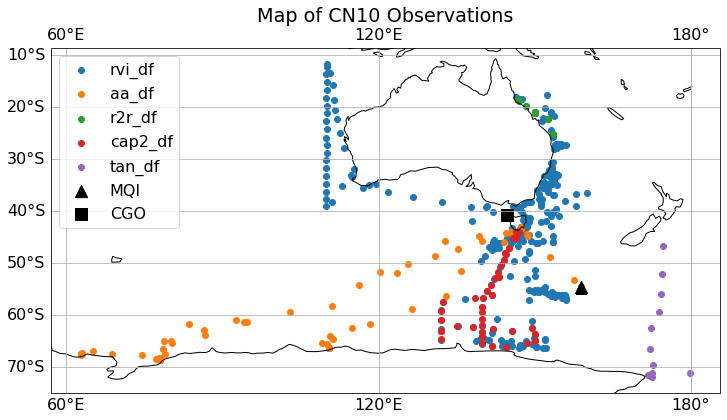

In [14]:
voyages = [rvi_df,aa_df,r2r_df,cap2_df,tan_df]

ax = plt.subplot(111, projection=ccrs.PlateCarree(140))
ax.figure.set_size_inches(12,10)
ax.coastlines();
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True);

for v in voyages:
    v = v.dropna('time')
    plt.scatter(y=v['lat'], 
                x=v['lon'],
                transform=ccrs.PlateCarree())

plt.scatter(x=158.861, y=-54.6199, s=150, c='black', marker='^', 
            transform=ccrs.PlateCarree(), label='Macquarie Island')

plt.scatter(x=144.6833, y=-40.68333, s=150, c='black', marker='s', 
            transform=ccrs.PlateCarree(), label='Cape Grim')
    
plt.legend(['rvi_df','aa_df','r2r_df','cap2_df','tan_df','MQI','CGO'], loc='upper left')
plt.rcParams.update({'font.size': 16})
plt.title('Map of CN10 Observations')

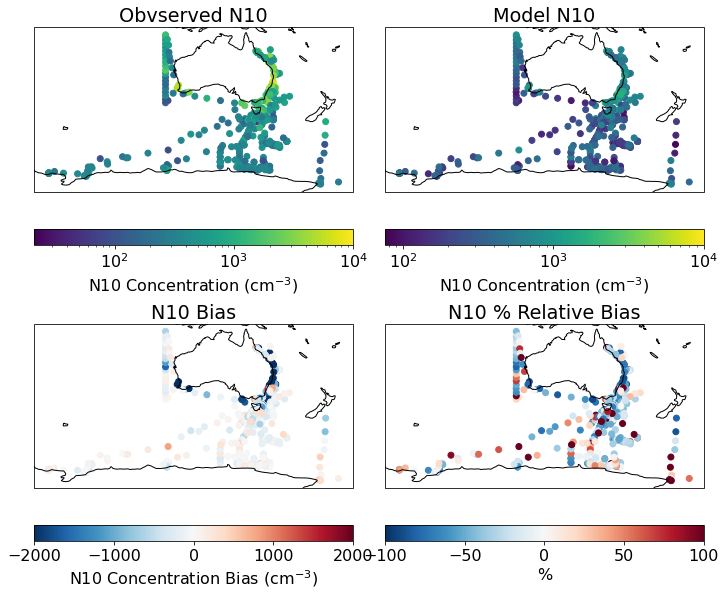

In [7]:
ax = plt.subplot(221, projection=ccrs.PlateCarree(140))
ax.figure.set_size_inches(12,10)
ax.coastlines();
plt.scatter(y=df['lat'], 
            x=df['lon'], 
            c=df['cn10_avg'], cmap='viridis', 
            norm=matplotlib.colors.LogNorm(vmax=10000), 
            transform=ccrs.PlateCarree())
plt.colorbar(label='N10 Concentration (cm$^{-3}$)', orientation='horizontal')
plt.title('Obvserved N10')

ax = plt.subplot(222, projection=ccrs.PlateCarree(140))
ax.coastlines();
plt.scatter(y=df['lat'], 
            x=df['lon'], 
            c=df['N10'], cmap='viridis', 
            norm=matplotlib.colors.LogNorm(vmax=10000), 
            transform=ccrs.PlateCarree())
plt.colorbar(label='N10 Concentration (cm$^{-3}$)', orientation='horizontal')
plt.title('Model N10')

ax = plt.subplot(223, projection=ccrs.PlateCarree(140))
ax.coastlines();
plt.scatter(y=df['lat'], 
            x=df['lon'], 
            c=(df['N10']-df['cn10_avg']), cmap='RdBu_r', 
            norm=matplotlib.colors.TwoSlopeNorm(vmin=-2000, vcenter=0, vmax=2000), 
            transform=ccrs.PlateCarree())
plt.colorbar(label='N10 Concentration Bias (cm$^{-3}$)', orientation='horizontal')
plt.title('N10 Bias')

ax = plt.subplot(224, projection=ccrs.PlateCarree(140))
ax.coastlines();
plt.scatter(y=df['lat'], 
            x=df['lon'], 
            c=((df['N10']-df['cn10_avg'])/df['cn10_avg']*100), cmap='RdBu_r', 
            norm=matplotlib.colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100), 
            transform=ccrs.PlateCarree())
plt.colorbar(label='%', orientation='horizontal')
plt.title('N10 % Relative Bias')

plt.subplots_adjust(hspace=0.2, wspace=0.1)

In [8]:
r = xr.corr(df.cn10_avg, df.N10)
r = np.array_str(r.values)

n = len(df.time)
n = str(n)

stat = 'R = '+r+', n = '+n

Text(17, 10000, 'R = 0.3868682615530519, n = 530')

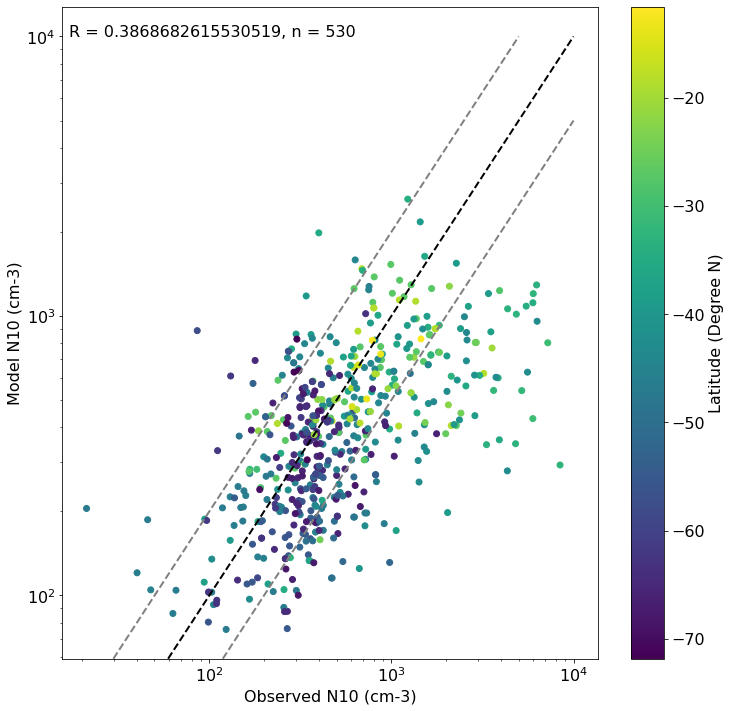

In [9]:
ax = plt.axes()
ax.figure.set_size_inches(12,12)
plt.scatter(data=df, x='cn10_avg',y='N10',c='lat')

plt.plot([0,10000],[0,10000], lw=2, color='black',linestyle='dashed')
plt.plot([0,5000],[0,10000], lw=2, color='grey',linestyle='dashed')
plt.plot([0,10000],[0,5000], lw=2, color='grey',linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed N10 (cm-3)')
plt.ylabel('Model N10 (cm-3)')
plt.colorbar(label='Latitude (Degree N)')

plt.text(17,10000, s=stat)

## Regional Evaluation <a class="anchor" id="second-bullet"></a>
* [Back to Top](#top)

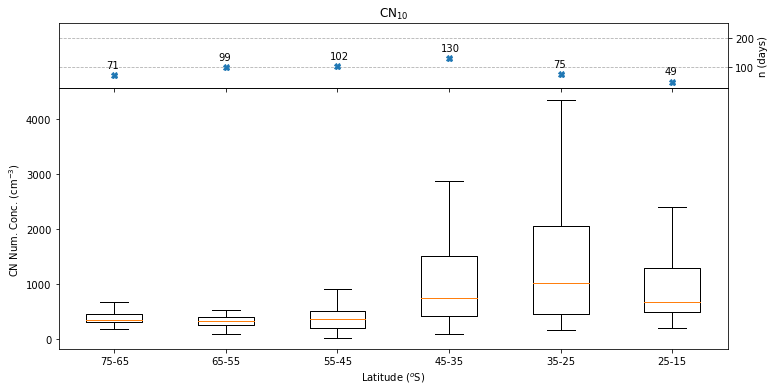

In [45]:
# Plot code 
step = 10
lat_bins = np.arange(-75,-10,step) # Create latitudinal bins

%matplotlib inline

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

d = df
col='cn10_avg'
title = 'CN$_{10}$'

d01 = d.where((d['lat']>=lat_bins[0]) & (d['lat']<lat_bins[1]))
d02 = d.where((d['lat']>=lat_bins[1]) & (d['lat']<lat_bins[2]))
d03 = d.where((d['lat']>=lat_bins[2]) & (d['lat']<lat_bins[3]))
d04 = d.where((d['lat']>=lat_bins[3]) & (d['lat']<lat_bins[4]))
d05 = d.where((d['lat']>=lat_bins[4]) & (d['lat']<lat_bins[5]))
d06 = d.where((d['lat']>=lat_bins[5]) & (d['lat']<lat_bins[6]))

labels = [str(-1*x) + '-' +str(-1*(x+step)) for x in lat_bins]
labels = labels[0:-1]

data_arr = [
        d01[col].dropna('time'),
        d02[col].dropna('time'),
        d03[col].dropna('time'),
        d04[col].dropna('time'),
        d05[col].dropna('time'),
        d06[col].dropna('time')
        ]

axs.boxplot(
            data_arr,
            notch=False,sym='',labels=labels
            )
axs.set_ylabel('CN Num. Conc. (cm$^{-3}$)')
axs.set_xlabel('Latitude ($^o$S)')
# axs.set_yscale('log')
# axs.set_ylim(0,700)
# set_axis_style(ax, labels)

divider = make_axes_locatable(axs)
histAx = divider.append_axes("top", size="25%", pad=0.)#, sharex=ax)

n = [len(d_arr) for d_arr in data_arr] #, b = np.histogram(d[col].dropna(), lon_bins, density=False)
h = histAx.plot(np.arange(1,len(data_arr)+1,1),n,'X')
histAx.yaxis.tick_right()
histAx.yaxis.set_label_position("right")
histAx.set_ylim([25,250])

histAx.set_xticklabels([])
histAx.set_ylabel("n (days)")

#histAx.set_ylim([5*10**2,5*10**5])
histAx.set_xlim([0.5,len(data_arr)+0.5])
histAx.grid(True,axis='y',linestyle='--')

histAx.set_title(title)

for x,y in zip(np.arange(1,len(data_arr)+1,1),n):

    label = str(int(y))

    plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-8,7), # distance from text to points (x,y)
                     ha='left') # horizontal alignment can be left, right or center
    
# axs.plot(3.2,cgo_df.cn10_avg,"*g",markersize=12)

# axs.plot(3.2,mqi_df.cn10_avg,"*g",markersize=12)

## Temporal Evaluation <a class="anchor" id="third-bullet"></a>
* [Back to Top](#top)

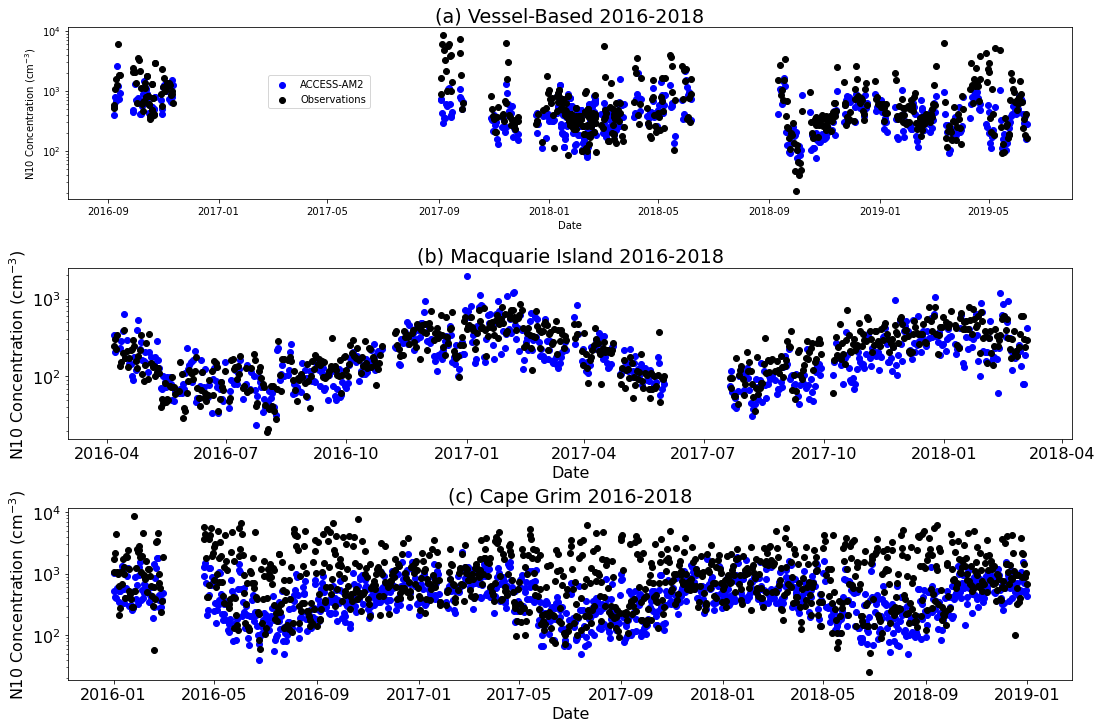

In [11]:
ax = plt.subplot(311)
ax.figure.set_size_inches(18, 12)
plt.scatter(df.time, df['N10'], color='blue', label='ACCESS-AM2')
plt.scatter(df.time, df['cn10_avg'], color='black', label='Observations')
plt.xlabel('Date')
plt.ylabel('N10 Concentration (cm$^{-3}$)')
plt.yscale('log')
plt.legend(bbox_to_anchor=(0, 0.5, 0.5, 0.5))
plt.rcParams.update({'font.size': 16})
plt.title('(a) Vessel-Based 2016-2018')

ax = plt.subplot(312)
plt.scatter(mqi_df.time, mqi_df['N10'], color='blue', label='ACCESS-AM2')
plt.scatter(mqi_df.time, mqi_df['cn10_avg'], color='black', label='Observations')
plt.xlabel('Date')
plt.ylabel('N10 Concentration (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.title('(b) Macquarie Island 2016-2018')

ax = plt.subplot(313)
plt.scatter(cgo_df.time, cgo_df['N10'], color='blue', label='ACCESS-AM2')
plt.scatter(cgo_df.time, cgo_df['cn10_avg'], color='black', label='Observations')
plt.xlabel('Date')
plt.ylabel('N10 Concentration (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.title('(c) Cape Grim 2016-2018')

plt.subplots_adjust(hspace=0.4, wspace=0.1)

In [12]:
df_S = df.groupby(df.time.dt.month).mean()
df_S['Count'] = df['lat'].groupby(df.time.dt.month).count()

mqi_S = mqi_df.groupby(mqi_df.time.dt.month).mean()
mqi_S['Count'] = mqi_df['lat'].groupby(mqi_df.time.dt.month).count()

cgo_S = cgo_df.groupby(cgo_df.time.dt.month).mean()
cgo_S['Count'] = cgo_df['lat'].groupby(cgo_df.time.dt.month).count()

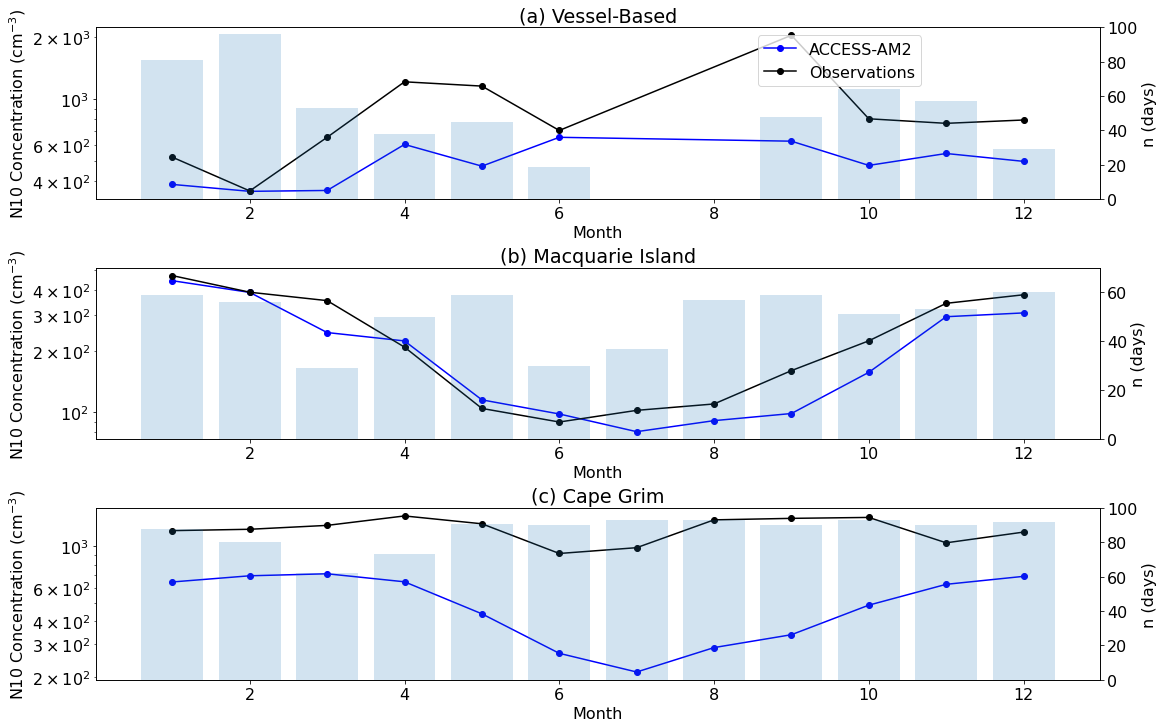

In [13]:
ax = plt.subplot(311)
ax.figure.set_size_inches(18, 12)
plt.plot(df_S.month, df_S['N10'], color='blue', marker='o', label='ACCESS-AM2')
plt.plot(df_S.month, df_S['cn10_avg'], color='black', marker='o',label='Observations')

plt.xlabel('Month')
plt.ylabel('N10 Concentration (cm$^{-3}$)')
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.33, 0.5, 0.5, 0.5))
plt.rcParams.update({'font.size': 16})
plt.title('(a) Vessel-Based')

ax2 = ax.twinx()
ax2.bar(df_S.month, df_S['Count'], alpha=0.2)
ax2.set_ylim(0,100)
ax2.set_ylabel("n (days)")

ax = plt.subplot(312)
plt.plot(mqi_S.month, mqi_S['N10'], color='blue', marker='o', label='ACCESS-AM2')
plt.plot(mqi_S.month, mqi_S['cn10_avg'], color='black', marker='o', label='Observations')

plt.xlabel('Month')
plt.ylabel('N10 Concentration (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.title('(b) Macquarie Island')

ax2 = ax.twinx()
ax2.bar(mqi_S.month, mqi_S['Count'], alpha=0.2)
ax2.set_ylim(0,70)
ax2.set_ylabel("n (days)")

ax = plt.subplot(313)
plt.plot(cgo_S.month, cgo_S['N10'], color='blue', marker='o', label='ACCESS-AM2')
plt.plot(cgo_S.month, cgo_S['cn10_avg'], color='black', marker='o', label='Observations')

plt.xlabel('Month')
plt.ylabel('N10 Concentration (cm$^{-3}$)')
plt.yscale('log')
plt.rcParams.update({'font.size': 16})
plt.title('(c) Cape Grim')

ax2 = ax.twinx()
ax2.bar(cgo_S.month, cgo_S['Count'], alpha=0.2)
ax2.set_ylim(0,100)
ax2.set_ylabel("n (days)")

plt.subplots_adjust(hspace=0.4, wspace=0.1)
# plt.savefig('fig4',bbox_inches='tight')

## Radon Evaluation <a class="anchor" id="fourth-bullet"></a>
* [Back to Top](#top)

Text(0.5, 1.0, 'Radon Activity')

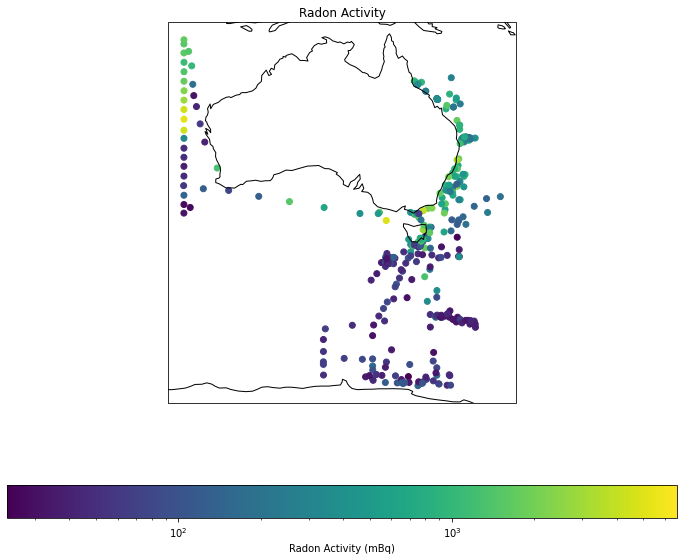

In [24]:
ax = plt.subplot(111, projection=ccrs.PlateCarree(140))
ax.figure.set_size_inches(12,10)
ax.coastlines();
plt.scatter(y=df_R['lat'], 
            x=df_R['lon'], 
            c=df_R['radon'], cmap='viridis', 
            norm=matplotlib.colors.LogNorm(),
            transform=ccrs.PlateCarree())
plt.colorbar(label='Radon Activity (mBq)', orientation='horizontal')
plt.title('Radon Activity')

## BLN Evaluation <a class="anchor" id="fifth-bullet"></a>
* [Back to Top](#top)